# Negative L1 norm prior experiment

This code attempts to learn the 32D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 22717.701171875
iteration 0 loss 12900.173828125


iteration 5000 loss 61.93626022338867


iteration 10000 loss 5.030679225921631


iteration 15000 loss 1.9720854759216309


iteration 20000 loss 1.3780092000961304


iteration 25000 loss 1.148842215538025


iteration 30000 loss 0.9859419465065002


iteration 35000 loss 0.8746471405029297


iteration 40000 loss 0.8115174770355225


iteration 45000 loss 0.7544696927070618


iteration 50000 loss 0.7110404372215271


iteration 55000 loss 0.6769166588783264


iteration 60000 loss 0.6443145275115967


iteration 65000 loss 0.6203864216804504


iteration 70000 loss 0.5999024510383606


iteration 75000 loss 0.5784776210784912


iteration 80000 loss 0.5606307983398438


iteration 85000 loss 0.5425026416778564


iteration 90000 loss 0.5263531804084778


iteration 95000 loss 0.5102376937866211


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.496917188167572


iteration 105000 loss 0.4931129813194275


iteration 110000 loss 0.4804040789604187


iteration 115000 loss 0.4662936329841614


iteration 120000 loss 0.45496824383735657


iteration 125000 loss 0.44334012269973755


iteration 130000 loss 0.4316193759441376


iteration 135000 loss 0.42119497060775757


iteration 140000 loss 0.41043806076049805


iteration 145000 loss 0.40123260021209717


iteration 150000 loss 0.39025184512138367


iteration 155000 loss 0.3817887604236603


iteration 160000 loss 0.37288713455200195


iteration 165000 loss 0.3636956512928009


iteration 170000 loss 0.35632047057151794


iteration 175000 loss 0.3486471176147461


iteration 180000 loss 0.3388063907623291


iteration 185000 loss 0.3313816785812378


iteration 190000 loss 0.32363834977149963


iteration 195000 loss 0.31396710872650146


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.3069549798965454


iteration 205000 loss 0.3052704632282257


iteration 210000 loss 0.29735103249549866


iteration 215000 loss 0.28871777653694153


iteration 220000 loss 0.2805837094783783


iteration 225000 loss 0.2728527784347534


iteration 230000 loss 0.26546743512153625


iteration 235000 loss 0.25836992263793945


iteration 240000 loss 0.25155141949653625


iteration 245000 loss 0.2449631243944168


iteration 250000 loss 0.23863659799098969


iteration 255000 loss 0.2325420081615448


iteration 260000 loss 0.2267022430896759


iteration 265000 loss 0.22108601033687592


iteration 270000 loss 0.21568793058395386


iteration 275000 loss 0.2105293720960617


iteration 280000 loss 0.2055402547121048


iteration 285000 loss 0.20080168545246124


iteration 290000 loss 0.19623516499996185


iteration 295000 loss 0.19183869659900665


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.1876383274793625


iteration 305000 loss 0.18697991967201233


iteration 310000 loss 0.18619953095912933


iteration 315000 loss 0.1854492872953415


iteration 320000 loss 0.1847173571586609


iteration 325000 loss 0.18399932980537415


iteration 330000 loss 0.18329332768917084


iteration 335000 loss 0.18259717524051666


iteration 340000 loss 0.1819101721048355


iteration 345000 loss 0.18123161792755127


iteration 350000 loss 0.18056084215641022


iteration 355000 loss 0.17989715933799744


iteration 360000 loss 0.17924046516418457


iteration 365000 loss 0.17858974635601044


iteration 370000 loss 0.1779451221227646


iteration 375000 loss 0.17730651795864105


iteration 380000 loss 0.17667372524738312


iteration 385000 loss 0.17604641616344452


iteration 390000 loss 0.17542459070682526


iteration 395000 loss 0.17480798065662384


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.1741967797279358


iteration 405000 loss 0.17414602637290955


iteration 410000 loss 0.1740950495004654


iteration 415000 loss 0.17404456436634064


iteration 420000 loss 0.17399457097053528


iteration 425000 loss 0.17394477128982544


iteration 430000 loss 0.17389532923698425


iteration 435000 loss 0.17384614050388336


iteration 440000 loss 0.17379693686962128


iteration 445000 loss 0.1737481653690338


iteration 450000 loss 0.17369943857192993


iteration 455000 loss 0.17365092039108276


iteration 460000 loss 0.1736026108264923


iteration 465000 loss 0.17355433106422424


iteration 470000 loss 0.1735062450170517


iteration 475000 loss 0.17345833778381348


iteration 480000 loss 0.17341046035289764


iteration 485000 loss 0.17336268723011017


iteration 490000 loss 0.17331518232822418


iteration 495000 loss 0.1732676774263382


L2 loss -- Plot

loss 57.14612579345703


loss -30.019853591918945


loss -69.27613830566406


loss -86.50733947753906


loss -93.03965759277344


loss -95.1537094116211


loss -95.71171569824219


loss -95.82261657714844


loss -95.83753967285156


loss -95.83872985839844


loss -95.83877563476562


loss -95.83877563476562


loss -95.83877563476562


loss -95.83877563476562


loss -95.83877563476562


loss -95.8387680053711


loss -95.8387680053711


loss -95.83877563476562


loss -95.83876037597656


loss -95.83876037597656


loss -95.8387680053711


loss -95.8387680053711


loss -95.8387680053711


loss -95.83876037597656


loss -95.83877563476562


loss -95.83876037597656


loss -95.83876037597656


loss -95.83876037597656


loss -95.83876037597656


loss -95.83876037597656


loss -95.83876037597656


loss -95.83876037597656


loss -95.83876037597656


loss -95.83876037597656


loss -95.8387680053711


loss -95.83876037597656


loss -95.83876037597656


loss -95.83877563476562


loss -95.83877563476562


loss -95.83877563476562


final mse:  2.002053101080037e-08
max, min: 1.6958023 -2.074536
loss 57.14612579345703


loss -24.968507766723633


loss -54.99971008300781


loss -65.10990142822266


loss -67.79663848876953


loss -68.34886932373047


loss -68.43302917480469


loss -68.44190216064453


loss -68.44246673583984


loss -68.44248962402344


loss -68.44248962402344


loss -68.44248962402344


loss -68.44248962402344


loss -68.44248962402344


loss -68.4424819946289


loss -68.44248962402344


loss -68.44248962402344


loss -68.44248962402344


loss -68.44248962402344


loss -68.44248962402344


loss -68.44248962402344


loss -68.4424819946289


loss -68.44248962402344


loss -68.4424819946289


loss -68.4424819946289


loss -68.4424819946289


loss -68.4424819946289


loss -68.4424819946289


loss -68.44248962402344


loss -68.44247436523438


loss -68.4424819946289


loss -68.4424819946289


loss -68.44247436523438


loss -68.44247436523438


loss -68.44247436523438


loss -68.4424819946289


loss -68.44248962402344


loss -68.4424819946289


loss -68.4424819946289


loss -68.4424819946289


final mse:  3.164911888120514e-08
max, min: 1.4743165 -1.6387049


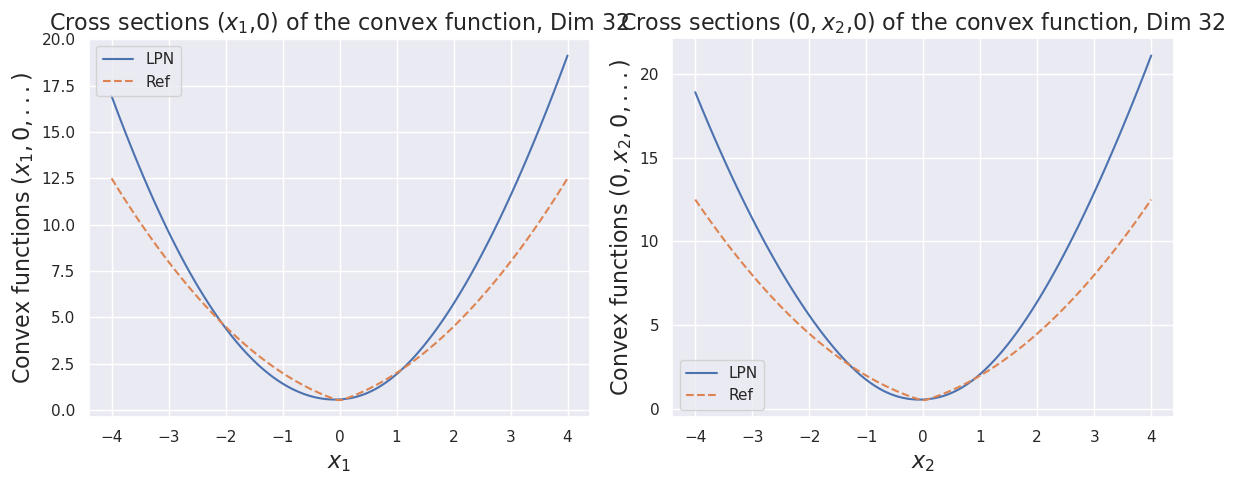

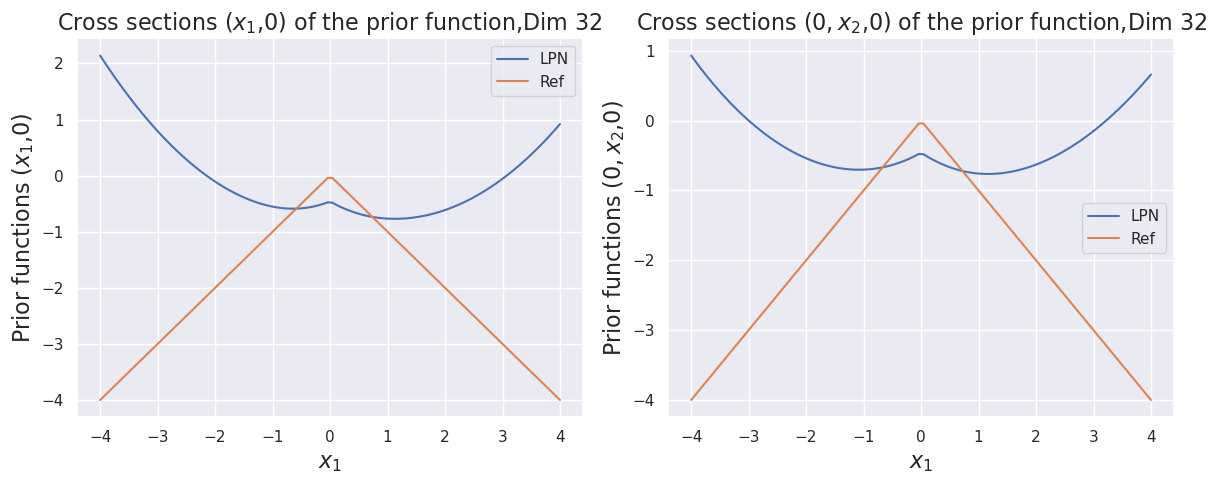

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 9003.5546875
iteration 0 loss 2211.6123046875


iteration 5000 loss 3.4426252841949463


iteration 10000 loss 1.277142882347107


iteration 15000 loss 0.8197454810142517


iteration 20000 loss 0.6589068174362183


iteration 25000 loss 0.5514368414878845


iteration 30000 loss 0.41025203466415405


iteration 35000 loss 0.4367251694202423


iteration 40000 loss 0.4018034040927887


iteration 45000 loss 0.2915809154510498


iteration 50000 loss 0.26894399523735046


iteration 55000 loss 12.806641578674316


iteration 60000 loss 0.2237350046634674


iteration 65000 loss 0.21552704274654388


iteration 70000 loss 0.19876757264137268


iteration 75000 loss 0.18410228192806244


iteration 80000 loss 0.28885024785995483


iteration 85000 loss 0.16219989955425262


iteration 90000 loss 0.15418095886707306


iteration 95000 loss 0.1457948237657547


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.13983112573623657


iteration 105000 loss 0.13272248208522797


iteration 110000 loss 0.1254529505968094


iteration 115000 loss 0.11899455636739731


iteration 120000 loss 0.11344887316226959


iteration 125000 loss 0.10875874012708664


iteration 130000 loss 0.10416443645954132


iteration 135000 loss 0.1004103273153305


iteration 140000 loss 0.09664630144834518


iteration 145000 loss 0.09299024194478989


iteration 150000 loss 0.08997871726751328


iteration 155000 loss 0.0869775041937828


iteration 160000 loss 0.08422662317752838


iteration 165000 loss 0.0817180722951889


iteration 170000 loss 0.07933935523033142


iteration 175000 loss 0.07718425244092941


iteration 180000 loss 0.07526480406522751


iteration 185000 loss 0.07319622486829758


iteration 190000 loss 0.0713055431842804


iteration 195000 loss 0.069437675178051


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.06756678223609924


iteration 205000 loss 0.06620720028877258


iteration 210000 loss 0.06462879478931427


iteration 215000 loss 0.06264333426952362


iteration 220000 loss 0.06126485392451286


iteration 225000 loss 0.05974949896335602


iteration 230000 loss 0.05813389644026756


iteration 235000 loss 0.05666936933994293


iteration 240000 loss 0.055580832064151764


iteration 245000 loss 0.05447404831647873


iteration 250000 loss 0.05328251048922539


iteration 255000 loss 0.05210556462407112


iteration 260000 loss 0.05111943930387497


iteration 265000 loss 0.05002071335911751


iteration 270000 loss 0.04909311234951019


iteration 275000 loss 0.048262108117341995


iteration 280000 loss 0.047367945313453674


iteration 285000 loss 0.046400703489780426


iteration 290000 loss 0.045622412115335464


iteration 295000 loss 0.044838547706604004


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.04392664507031441


iteration 305000 loss 0.04376819357275963


iteration 310000 loss 0.0427275151014328


iteration 315000 loss 0.04147352650761604


iteration 320000 loss 0.04028857499361038


iteration 325000 loss 0.039167389273643494


iteration 330000 loss 0.03811062499880791


iteration 335000 loss 0.037097685039043427


iteration 340000 loss 0.036131177097558975


iteration 345000 loss 0.03521063178777695


iteration 350000 loss 0.034337010234594345


iteration 355000 loss 0.033498700708150864


iteration 360000 loss 0.03269123658537865


iteration 365000 loss 0.031919077038764954


iteration 370000 loss 0.03118014521896839


iteration 375000 loss 0.03047504834830761


iteration 380000 loss 0.029795799404382706


iteration 385000 loss 0.02914048731327057


iteration 390000 loss 0.028507720679044724


iteration 395000 loss 0.027897944673895836


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.027309224009513855


iteration 405000 loss 0.027190065011382103


iteration 410000 loss 0.027031932026147842


iteration 415000 loss 0.026880163699388504


iteration 420000 loss 0.0267323087900877


iteration 425000 loss 0.026587417349219322


iteration 430000 loss 0.026445018127560616


iteration 435000 loss 0.02630474790930748


iteration 440000 loss 0.026166299358010292


iteration 445000 loss 0.02602943405508995


iteration 450000 loss 0.02589414082467556


iteration 455000 loss 0.025760216638445854


iteration 460000 loss 0.02562754787504673


iteration 465000 loss 0.02549615502357483


iteration 470000 loss 0.02536594122648239


iteration 475000 loss 0.025236938148736954


iteration 480000 loss 0.02510901354253292


iteration 485000 loss 0.02498212829232216


iteration 490000 loss 0.024856148287653923


iteration 495000 loss 0.024731101468205452


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


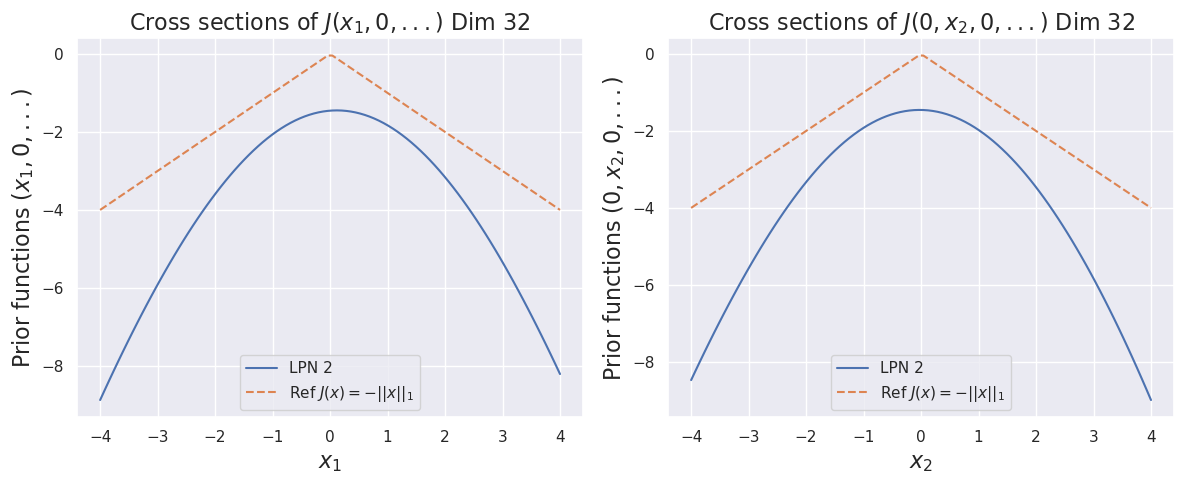

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)